In [1]:
#importing required libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_text
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
!pip install xgboost
import xgboost as xgb

In [2]:
df= pd.read_csv('car_fuel_efficiency.csv')
df.head()

,engine_displacement,num_cylinders,horsepower,vehicle_weight,acceleration,model_year,origin,fuel_type,drivetrain,num_doors,fuel_efficiency_mpg
0,170,3.0,159.0,3413.433759,17.7,2003,Europe,Gasoline,All-wheel drive,0.0,13.231729
1,130,5.0,97.0,3149.664934,17.8,2007,USA,Gasoline,Front-wheel drive,0.0,13.688217
2,170,NaN,78.0,3079.038997,15.1,2018,Europe,Gasoline,Front-wheel drive,0.0,14.246341
3,220,4.0,NaN,2542.392402,20.2,2009,USA,Diesel,All-wheel drive,2.0,16.912736
4,210,1.0,140.0,3460.870990,14.4,2009,Europe,Gasoline,All-wheel drive,2.0,12.488369


#### Data Preparation

In [3]:
df= df.fillna(0)
df.head()

,engine_displacement,num_cylinders,horsepower,vehicle_weight,acceleration,model_year,origin,fuel_type,drivetrain,num_doors,fuel_efficiency_mpg
0,170,3.0,159.0,3413.433759,17.7,2003,Europe,Gasoline,All-wheel drive,0.0,13.231729
1,130,5.0,97.0,3149.664934,17.8,2007,USA,Gasoline,Front-wheel drive,0.0,13.688217
2,170,0.0,78.0,3079.038997,15.1,2018,Europe,Gasoline,Front-wheel drive,0.0,14.246341
3,220,4.0,0.0,2542.392402,20.2,2009,USA,Diesel,All-wheel drive,2.0,16.912736
4,210,1.0,140.0,3460.870990,14.4,2009,Europe,Gasoline,All-wheel drive,2.0,12.488369


In [4]:
df_full_train, df_test= train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val= train_test_split(df_full_train, test_size=0.25, random_state= 1)

In [5]:
df_train= df_train.reset_index(drop= True)
df_val= df_val.reset_index(drop= True)
df_test= df_test.reset_index(drop= True)

In [6]:
y_train= df_train.fuel_efficiency_mpg
y_val= df_val.fuel_efficiency_mpg
y_test= df_test.fuel_efficiency_mpg

In [7]:
del df_train['fuel_efficiency_mpg']
del df_val['fuel_efficiency_mpg']
del df_test['fuel_efficiency_mpg']

In [8]:
train_dict= df_train.to_dict(orient= 'records')
val_dict= df_val.to_dict(orient= 'records')
test_dict= df_test.to_dict(orient= 'records')

In [9]:
dv= DictVectorizer(sparse= True)
X_train= dv.fit_transform(train_dict)
X_val= dv.transform(val_dict)
X_test= dv.transform(test_dict)

Question 1: Which feature is used for splitting the data?

In [10]:
dt= DecisionTreeRegressor(max_depth= 1)

In [11]:
dt.fit(X_train,y_train)

DecisionTreeRegressor(max_depth=1)

In [12]:
print(export_text(dt, feature_names= dv.get_feature_names_out()))

|--- vehicle_weight <= 3022.11
|   |--- value: [16.88]
|--- vehicle_weight >  3022.11
|   |--- value: [12.94]



Answer 1: 'vehicle weight'

Question 2: What's the RMSE of this model on the validation data?

In [13]:
rf= RandomForestRegressor(n_estimators=10,
                          random_state=1,
                          n_jobs=-1 )

In [14]:
rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=1)

In [15]:
y_pred= rf.predict(X_val)

In [16]:
rmse= np.sqrt(mean_squared_error(y_val, y_pred))
print('rmse: ', rmse)            

rmse:  0.4595777223092726


Answer 2: 0.45

Question 3: After which value of n_estimators does RMSE stop improving? Consider 3 decimal places for calculating the answer. 

In [17]:
scores= []
estimators= np.arange(10, 201, 10)
for n in estimators:
    rf2= RandomForestRegressor(n_estimators=n,
                          random_state=1,
                          n_jobs=-1 )
    rf2.fit(X_train, y_train)
    y_pred= rf2.predict(X_val)
    rmse= np.sqrt(mean_squared_error(y_val, y_pred)) 
    scores.append((n, np.round(rmse, 3)))
df_scores= pd.DataFrame(scores, columns= ['n_estimators', 'root_mean_squared_error'])
df_scores   

,n_estimators,root_mean_squared_error
0,10,0.460
1,20,0.454
2,30,0.452
3,40,0.449
4,50,0.447
5,60,0.445
6,70,0.445
7,80,0.445
8,90,0.445
9,100,0.445


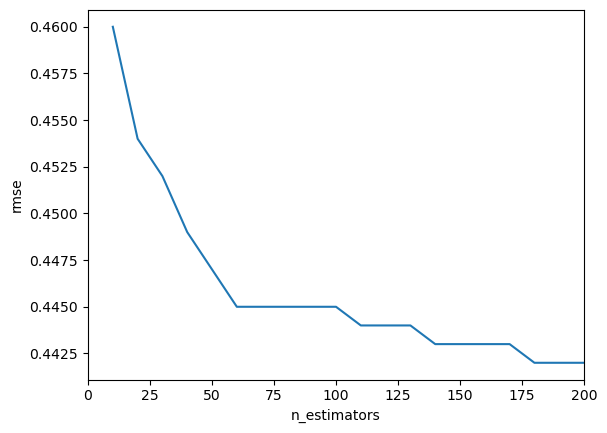

In [18]:
plt.plot(df_scores['n_estimators'], df_scores['root_mean_squared_error'])
plt.xlabel('n_estimators')
plt.ylabel('rmse')
plt.xlim(0,200)
plt.show()

Answer 3: n_estimators= 80

Question 4: What's the best max_depth, using the mean RMSE?

In [19]:
scores2= []
depths= [10, 15, 20, 25]
estimators= np.arange(10, 201, 10)
for d in depths:
    for n in estimators:
        rf3= RandomForestRegressor(n_estimators=n,
                                   max_depth= d,  
                                  random_state=1,
                                  n_jobs=-1 )
        rf3.fit(X_train, y_train)
        y_pred= rf3.predict(X_val)
        rmse= np.sqrt(mean_squared_error(y_val, y_pred)) 
        scores2.append((d, n, rmse))
df_scores2= pd.DataFrame(scores2, columns= ['max_depth','n_estimators', 'root_mean_squared_error'])
df_scores2


,max_depth,n_estimators,root_mean_squared_error
0,10,10,0.450249
1,10,20,0.446857
2,10,30,0.445474
3,10,40,0.443067
4,10,50,0.441957
...,...,...,...
75,25,160,0.442800
76,25,170,0.442843
77,25,180,0.442409
78,25,190,0.442534


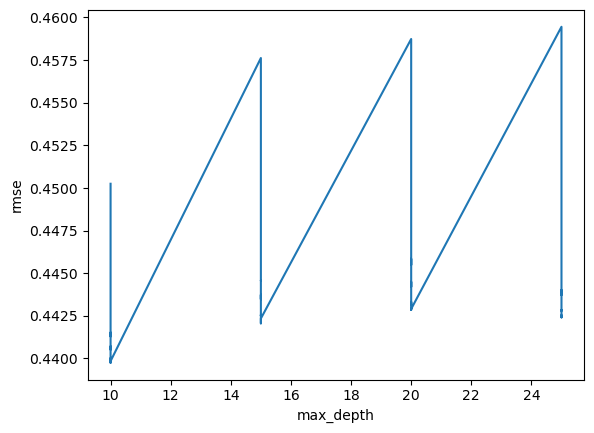

In [20]:
plt.plot(df_scores2['max_depth'], df_scores2['root_mean_squared_error'])
plt.xlabel('max_depth')
plt.ylabel('rmse')
plt.show()

Answer 4: best_max_depth= 10

Question 5: What's the most important feature (among these 4)?

In [21]:
rf4= RandomForestRegressor(n_estimators= 10,
                                   max_depth= 20,  
                                  random_state=1,
                                  n_jobs=-1 )
rf4.fit(X_train, y_train)
print(rf4.feature_importances_)      

[1.14797006e-02 3.57108549e-04 3.45384113e-04 3.27279191e-03
 3.25424323e-04 3.60383601e-04 1.59978977e-02 3.21230009e-03
 2.34334695e-03 1.63498954e-03 4.62246496e-04 5.18739639e-04
 5.39721689e-04 9.59149965e-01]


In [22]:
importance= pd.DataFrame({'Feature': list(dv.get_feature_names_out()), 
                                          'Feature Importance': rf4.feature_importances_}).sort_values('Feature Importance', ascending=False) 
importance

,Feature,Feature Importance
13,vehicle_weight,0.959150
6,horsepower,0.015998
0,acceleration,0.011480
3,engine_displacement,0.003273
7,model_year,0.003212
8,num_cylinders,0.002343
9,num_doors,0.001635
12,origin=USA,0.000540
11,origin=Europe,0.000519
10,origin=Asia,0.000462


Answer 5: Most important feature: vehicle_weight

Question 6: Which eta leads to the best RMSE score on the validation dataset?

In [23]:
dtrain= xgb.DMatrix(X_train, label= y_train, feature_names= list(dv.get_feature_names_out()))
dval= xgb.DMatrix(X_val, label= y_val, feature_names= list(dv.get_feature_names_out()))

In [24]:
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

In [25]:
watchlist= [(dtrain, 'train'), (dval, 'val')]

In [26]:
model= xgb.train(xgb_params, dtrain, num_boost_round= 100)

In [27]:
y_pred= model.predict(dval)
np.sqrt(mean_squared_error(y_val, y_pred))

np.float64(0.45017755678087246)

In [28]:
xgb_params2 = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

In [29]:
model= xgb.train(xgb_params2, dtrain, num_boost_round= 100)

In [30]:
y_pred= model.predict(dval)
np.sqrt(mean_squared_error(y_val, y_pred))

np.float64(0.42622800553359225)

Answer 6: eta: 0.1